# 1. 实验前导

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.utils.data as tud
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# 2. 准备数据

In [2]:
'''
mnist_data = datasets.MNIST("./mnist_data",train=True,download=True,
                                 transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=(0.13066062,),std=(0.30810776,))
                                 ]))                             
batch_size = 32
dataloader = tud.DataLoader(mnist_data,batch_size = batch_size,shuffle=True)          # 将dataset转换为iterator
'''
mnist_data = datasets.MNIST("./mnist_data",train=True,download=True,
                                 transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=(0.5,),std=(0.5,))
                                 ]))
batch_size = 32
dataloader = tud.DataLoader(mnist_data,batch_size = batch_size,shuffle=True)          # 将dataset转换为iterator

# 3. 配置网络

In [9]:
image_size = 28 * 28
hidden_size = 256
# 判别器
# write your code here
# 写一个判别器
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

latent_size = 64
# 生成器
# write your code here
# G = nn.Sequential(....)
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)

D = D.to(device)
G = G.to(device)

# define your loss function
# write your code here
loss_fn = nn.BCELoss()
# define your optimizer
# write your code here(需要分别定义生成器和判别器的优化器)
d_optimizer = torch.optim.Adam(D.parameters(),lr=0.0003)
g_optimizer = torch.optim.Adam(G.parameters(),lr=0.0003)

# 4. 训练网络

In [10]:
total_steps = len(dataloader)
num_epochs = 30
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(dataloader):
        batch_size = images.shape[0]
        images = images.reshape(batch_size,image_size).to(device)
        real_labels = torch.ones(batch_size,1).to(device) #生成全1的标签
        fake_labels = torch.zeros(batch_size,1).to(device)#生成全0的标签
        
        ### 判别器的训练过程
        # write your code here
        outputs = D(images)
        d_loss_real = loss_fn(outputs,real_labels)
        real_score = outputs
        
        z = torch.randn(batch_size,latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images.detach())
        d_loss_fake = loss_fn(outputs,fake_labels)
        fake_score = outputs
        
        d_loss = d_loss_real + d_loss_fake
        
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()        
        
        
        ### 生成器的训练过程
        # write your code here
        
        outputs = D(fake_images)
        g_loss = loss_fn(outputs,real_labels)
        g_score = outputs
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
       

        ### 输出训练过程        
        if i % 200 == 0:
            print("Epoch [{}/{}], Step [{}/{}], d_loss:{:.4f}, g_loss:{:.4f}, D(x):{:.2f}, D(G(z)):{:.2f}, G(z):{:.2f}"
                 .format(epoch, num_epochs,i, total_steps, d_loss.item(), g_loss.item(), 
                         real_score.mean().item(), fake_score.mean().item(), g_score.mean().item()))
        

Epoch [0/30], Step [0/1875], d_loss:1.3890, g_loss:0.6906, D(x):0.50, D(G(z)):0.50, G(z):0.50
Epoch [0/30], Step [200/1875], d_loss:0.5552, g_loss:1.6737, D(x):0.91, D(G(z)):0.37, G(z):0.19
Epoch [0/30], Step [400/1875], d_loss:0.0331, g_loss:6.2632, D(x):0.99, D(G(z)):0.02, G(z):0.00
Epoch [0/30], Step [600/1875], d_loss:0.2042, g_loss:2.8373, D(x):0.99, D(G(z)):0.17, G(z):0.07
Epoch [0/30], Step [800/1875], d_loss:0.6560, g_loss:2.2893, D(x):0.87, D(G(z)):0.36, G(z):0.11
Epoch [0/30], Step [1000/1875], d_loss:0.1131, g_loss:5.0538, D(x):0.97, D(G(z)):0.07, G(z):0.02
Epoch [0/30], Step [1200/1875], d_loss:0.7589, g_loss:1.7265, D(x):0.90, D(G(z)):0.44, G(z):0.19
Epoch [0/30], Step [1400/1875], d_loss:1.4943, g_loss:1.8590, D(x):0.54, D(G(z)):0.28, G(z):0.20
Epoch [0/30], Step [1600/1875], d_loss:0.4531, g_loss:2.2852, D(x):0.81, D(G(z)):0.11, G(z):0.12
Epoch [0/30], Step [1800/1875], d_loss:0.9846, g_loss:2.1150, D(x):0.64, D(G(z)):0.31, G(z):0.15
Epoch [1/30], Step [0/1875], d_loss:1

In [13]:
real_labels.shape

torch.Size([32, 1])

# 5. 模型评估

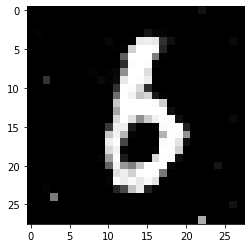

In [14]:
z = torch.randn(batch_size,latent_size).to(device)# 随机生成一个Batch的向量
fake_images = G(z) # 生成该Batch向量的图像
fake_images = fake_images.view(batch_size,28,28).data.cpu().numpy() # 将图像转化为二维，以便展示
plt.imshow(fake_images[0],cmap=plt.cm.gray) # 挑选Batch的第一个图像，进行展示

# 6. 模型存储

In [15]:
torch.save(G.state_dict(),"mnist_generator.pth")
torch.save(D.state_dict(),"mnist_discriminator.pth")

### Load模型评估

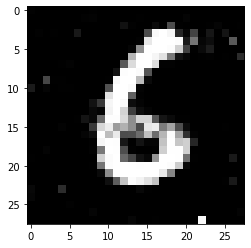

In [27]:
image_size = 28 * 28
hidden_size = 256
latent_size = 64
batch_size = 32
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size,image_size),
    nn.Tanh()    
)
G = G.to(device)
G.load_state_dict(torch.load("mnist_generator.pth"))
z = torch.randn(batch_size,latent_size).to(device)
fake_images = G(z)
fake_images = fake_images.view(batch_size,28,28).data.cpu().numpy()
plt.imshow(fake_images[0],cmap=plt.cm.gray)

## 拓展代码

Epoch [1/100], Step [1/938], Generator Loss: 0.7227, Discriminator Loss: 0.7054
Epoch [1/100], Step [201/938], Generator Loss: 0.3047, Discriminator Loss: 0.8003
Epoch [1/100], Step [401/938], Generator Loss: 0.3977, Discriminator Loss: 0.6897
Epoch [1/100], Step [601/938], Generator Loss: 1.3082, Discriminator Loss: 0.4840
Epoch [1/100], Step [801/938], Generator Loss: 0.9840, Discriminator Loss: 0.4842
Epoch [2/100], Step [1/938], Generator Loss: 1.3368, Discriminator Loss: 0.4884
Epoch [2/100], Step [201/938], Generator Loss: 1.5333, Discriminator Loss: 0.6825
Epoch [2/100], Step [401/938], Generator Loss: 1.5726, Discriminator Loss: 0.5720
Epoch [2/100], Step [601/938], Generator Loss: 1.4091, Discriminator Loss: 0.4837
Epoch [2/100], Step [801/938], Generator Loss: 1.2981, Discriminator Loss: 0.4168
Epoch [3/100], Step [1/938], Generator Loss: 0.6658, Discriminator Loss: 0.5044
Epoch [3/100], Step [201/938], Generator Loss: 0.4927, Discriminator Loss: 0.5994
Epoch [3/100], Step [4

TypeError: Invalid shape (28,) for image data

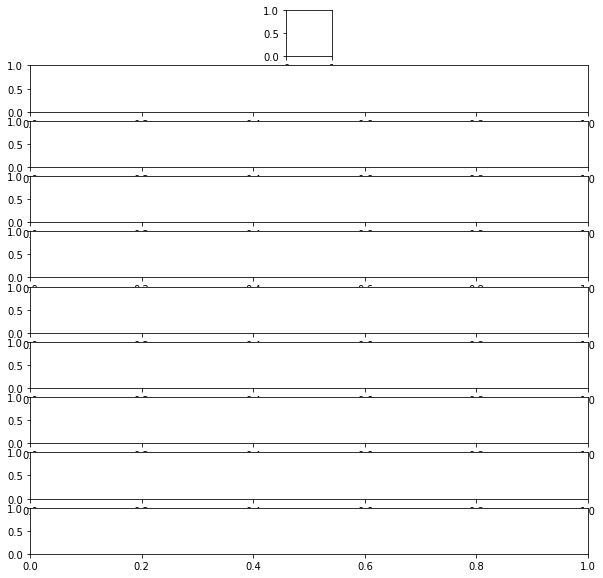

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the generator network
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_shape):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.img_shape = img_shape
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, int(torch.prod(torch.tensor(img_shape)))),
            nn.Tanh()
        )
        
    def forward(self, noise, labels):
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *self.img_shape)
        return img

# Define the discriminator network
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_shape):
        super(Discriminator, self).__init__()
        self.num_classes = num_classes
        self.img_shape = img_shape
        
        self.label_emb = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(num_classes + int(torch.prod(torch.tensor(img_shape))), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
        
    def forward(self, img, labels):
        d_in = torch.cat((img.view(img.size(0), -1), self.label_emb(labels)), -1)
        validity = self.model(d_in)
        return validity

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
latent_dim = 100
num_classes = 10
img_shape = (28, 28)

# Initialize generator and discriminator
generator = Generator(latent_dim, num_classes, img_shape).to(device)
discriminator = Discriminator(num_classes, img_shape).to(device)

# Define loss function and optimizers
adversarial_loss = nn.BCELoss()
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = datasets.MNIST(root="./mnist_data", train=True, transform=transform, download=True)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for i, (real_images, labels) in enumerate(train_dataloader):
        batch_size = real_images.size(0)
        
        # Adversarial ground truths
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        # Move real images and labels to device
        real_images = real_images.to(device)
        labels = labels.to(device)
        
        # Train generator
        generator_optimizer.zero_grad()
        
        # Generate fake images
        noise = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(noise, labels)
        
        # Loss measures generator's ability to fool the discriminator
        generator_loss = adversarial_loss(discriminator(fake_images, labels), real_labels)
        
        # Backpropagation
        generator_loss.backward()
        generator_optimizer.step()
        
        # Train discriminator
        discriminator_optimizer.zero_grad()
        
        # Measure discriminator's ability to classify real and fake images
        real_loss = adversarial_loss(discriminator(real_images, labels), real_labels)
        fake_loss = adversarial_loss(discriminator(fake_images.detach(), labels), fake_labels)
        discriminator_loss = (real_loss + fake_loss) / 2
        
        # Backpropagation
        discriminator_loss.backward()
        discriminator_optimizer.step()
        
        # Print training progress
        if i % 200 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}], "
                f"Step [{i+1}/{len(train_dataloader)}], "
                f"Generator Loss: {generator_loss.item():.4f}, "
                f"Discriminator Loss: {discriminator_loss.item():.4f}"
            )

# Generate and plot some samples
num_samples = 10
noise = torch.randn(num_samples, latent_dim).to(device)
labels = torch.arange(num_classes).repeat(num_samples // num_classes).to(device)
fake_images = generator(noise, labels).detach().cpu()

fig, axes = plt.subplots(nrows=num_classes, ncols=num_samples // num_classes, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(fake_images[i][0], cmap="gray")
    ax.axis("off")
    ax.set_title(f"Label: {labels[i].item()}")

plt.tight_layout()
plt.show()


In [30]:
# Define the file path to save the weights
weights_path = "model_weights.pth"

# Save the generator and discriminator weights
torch.save(generator.state_dict(), "generator" + weights_path)
torch.save(discriminator.state_dict(), "discriminator" + weights_path)


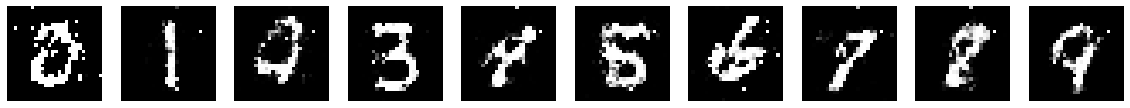

In [46]:
# Load the generator and discriminator models
generator = Generator(latent_dim, num_classes, img_shape).to(device)
discriminator = Discriminator(num_classes, img_shape).to(device)

# Load the saved weights
generator.load_state_dict(torch.load("generator" + weights_path))
discriminator.load_state_dict(torch.load("discriminator" + weights_path))

# Generate and plot some samples
num_samples = 10
noise = torch.randn(num_samples, latent_dim).to(device)
labels = torch.arange(num_classes).repeat(num_samples // num_classes).to(device)
fake_images = generator(noise, labels).detach().cpu()

fig, axs = plt.subplots(1, num_samples, figsize=(20, 4))
for i in range(num_samples):
    axs[i].imshow(fake_images[i].squeeze(), cmap='gray')
    axs[i].axis("off")
plt.show()
